# Agile Modeling for Bioacoustics.

This notebook provides a workflow for creating custom classifiers for target signals, by first **searching** for training data, and then engaging in an **active learning** loop.

We assume that embeddings have been pre-computed using `embed.ipynb`.

## Configuration and Imports.

Run in the perch_conda_env

In [2]:
 #@title Imports. { vertical-output: true }

import collections
from etils import epath
from ml_collections import config_dict
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tqdm
from chirp.inference import colab_utils
colab_utils.initialize(use_tf_gpu=True, disable_warnings=True)

from chirp import audio_utils
#from chirp.inference import a2o_utils
from chirp.inference import interface
from chirp.inference import tf_examples
from chirp.inference import models
from chirp.models import metrics
from chirp.taxonomy import namespace
from chirp.inference.search import bootstrap
from chirp.inference.search import search
from chirp.inference.search import display
from chirp.inference.classify import classify
from chirp.inference.classify import data_lib

# New
from chirp.inference import embed_lib
from IPython.display import display as ipy_display, HTML
import ipywidgets as widgets
import os
import shutil
import pandas as pd

2024-11-05 19:46:23.164390: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 19:46:23.262986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 19:46:23.314182: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 19:46:23.314671: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 19:46:23.405564: I tensorflow/core/platform/cpu_feature_gua

In [24]:
# Check tf can access the GPU
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


In [4]:
#@title Set Paths
base_dir = os.getenv('BASE_DIR')
if not base_dir:
    raise ValueError("BASE_DIR environment variable is not set.")

country = 'indonesia'
project_directory = os.path.join(base_dir, 'marrs_acoustics/data/output_dir_' + country)
embeddings_path = os.path.join(project_directory + '/raw_embeddings/')
#embeddings_path = '/content/gs/soundscapes/benwilliams_reef/embeddings/' ### new gc embeddings
all_target_sounds = os.path.join(project_directory + '/target_sounds/')

# Configs:
sample_rate = 32000
window_size = 5.0

In [5]:
#@title Basic Configuration. { vertical-output: true }

#@markdown Choose what data to work with.
#@markdown * For local data (most cases), choose 'filesystem'.
#@markdown * For Australian Acoustic Observatory, select 'a2o'.
#@markdown This will cause many options (like model_choice) to be overridden.
#@markdown Note that you will need an Authentication Token from:
#@markdown https://data.acousticobservatory.org/my_account
data_source = 'filesystem' #@param['filesystem', 'a2o']
a2o_auth_token = '' #@param {type:'string'}

#@markdown Define the model: Usually perch or birdnet.
model_choice = 'surfperch'  #@param {type:'string'}
#@markdown Set the base directory for the project.
working_dir = '/tmp/agile'  #@param {type:'string'}

#@markdown Set the embedding and labeled data directories.
#labeled_data_path = labeled_data_path ###epath.Path(working_dir) / 'labeled'
#custom_classifier_path = custom_classifier_path ###epath.Path(working_dir) / 'custom_classifier'

#@markdown The embeddings_path should be detected automatically, but can be
#@markdown overridden.
embeddings_path = embeddings_path

#@markdown OPTIONAL: Set up separation model.
separation_model_key = ''  #@param {type:'string'}
separation_model_path = ''  #@param {type:'string'}


In [6]:
#@title SurfPerch Configuration. { vertical-output: true }

config = config_dict.ConfigDict()
config.embed_fn_config = config_dict.ConfigDict()
config.embed_fn_config.model_config = config_dict.ConfigDict()

config.source_file_patterns = ['/media/mars_5tb_drive/mars_global_acoustic_study/indonesia_acoustics/raw_audio/*.[wW][aA][vV]']  #@param
config.output_dir = embeddings_path

#@markdown For Perch, set the perch_tfhub_model_version, and the model will load
#@markdown automagically from TFHub. Alternatively, set the model path for a
#@markdown local copy of the model.
#@markdown Note that only one of perch_model_path and perch_tfhub_version should
#@markdown be set.
#perch_tfhub_version = 8  #@param
surfperch_path = os.path.join(base_dir, 'marrs_acoustics/SurfPerch-model')

#@markdown For BirdNET, point to the specific tflite file.
config.embed_fn_config.model_key = 'taxonomy_model_tf'
config.embed_fn_config.model_config.window_size_s = window_size
config.embed_fn_config.model_config.hop_size_s = 5.0
config.embed_fn_config.model_config.sample_rate = sample_rate
#config.embed_fn_config.model_config.tfhub_version = perch_tfhub_version
config.embed_fn_config.model_config.model_path = surfperch_path

# Only write embeddings to reduce size.
config.embed_fn_config.write_embeddings = True
config.embed_fn_config.write_logits = False
config.embed_fn_config.write_separated_audio = False
config.embed_fn_config.write_raw_audio = False

# Number of parent directories to include in the filename.
config.embed_fn_config.file_id_depth = 1

# Uncomment to check the model path and fpr reef classes (e.g antrop_bomb) to be sure we've got SurfPerch
#embed_fn.embedding_model

In [7]:
#@title SurfPerch test run. { vertical-output: true }

# Set up the embedding function, including loading models.
embed_fn = embed_lib.EmbedFn(**config.embed_fn_config)
print('\n\nLoading model(s)...')
embed_fn.setup()

# Create output directory and write the configuration.
output_dir = epath.Path(config.output_dir)
output_dir.mkdir(exist_ok=True, parents=True)
#embed_lib.maybe_write_config(config, output_dir) ### comment out if accessing frm=om gc

# Create SourceInfos.
source_infos = embed_lib.create_source_infos(
    config.source_file_patterns,
    num_shards_per_file=config.get('num_shards_per_file', -1),
    shard_len_s=config.get('shard_len_s', -1))
print(f'Found {len(source_infos)} source infos.')

print('\n\nTest-run of model...')
window_size_s = config.embed_fn_config.model_config.window_size_s
sr = config.embed_fn_config.model_config.sample_rate
z = np.zeros([int(sr * window_size_s)])
embed_fn.embedding_model.embed(z)
print('Setup complete!')



Loading model(s)...


2024-11-05 19:46:37.591018: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-05 19:46:37.591224: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-05 19:46:37.591304: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Found 0 source infos.


Test-run of model...


I0000 00:00:1730836000.063622    8401 service.cc:145] XLA service 0x145c3da0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730836000.063651    8401 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-05 19:46:40.257912: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1730836000.279848    8401 assert_op.cc:38] Ignoring Assert operator jax2tf_infer_fn_/assert_equal_1/Assert/AssertGuard/Assert
2024-11-05 19:46:40.671053: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
2024-11-05 19:46:40.975224: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling 

Setup complete!


I0000 00:00:1730836005.995913    8401 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


## Select target sound

Number of different target sounds:  11
Target sound label:  wipe


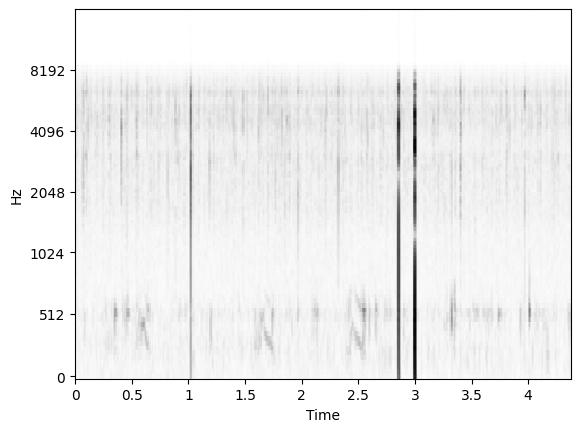

Target sound label:  oink


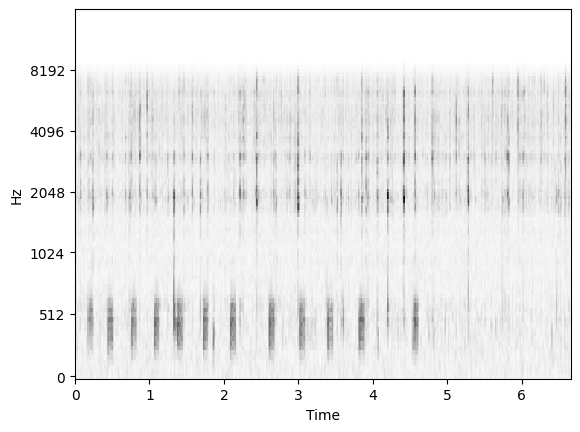

Target sound label:  laugh


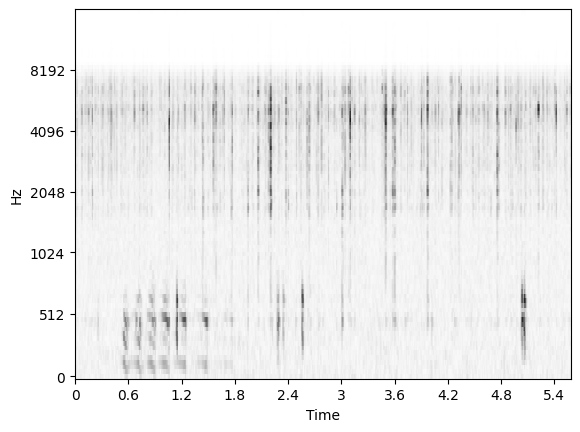

Target sound label:  rattle


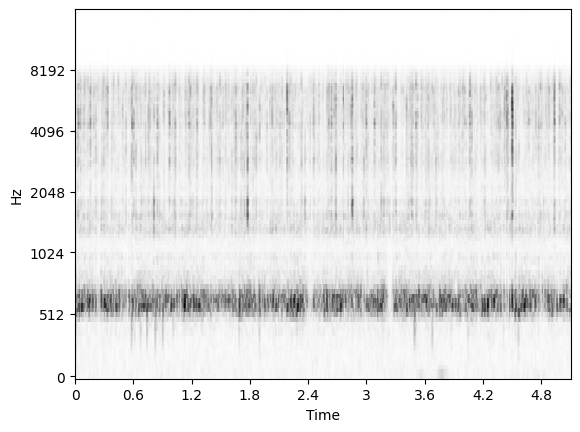

Target sound label:  scrape_fullband


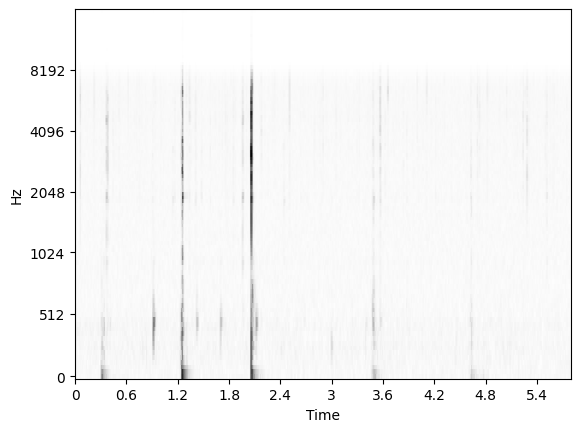

Target sound label:  scrape_lowband


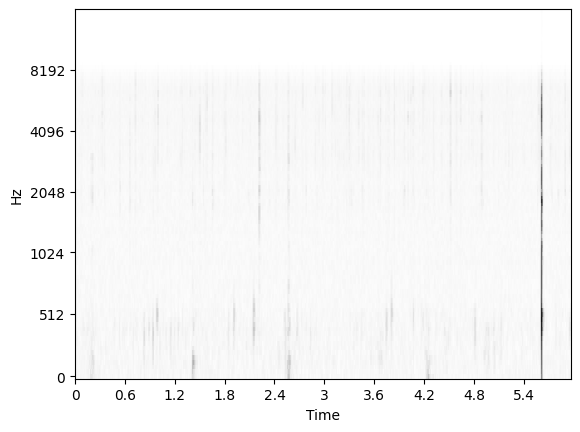

Target sound label:  foghorn


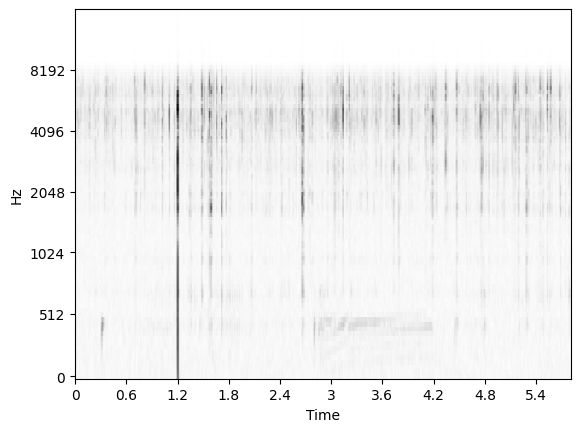

Target sound label:  croak


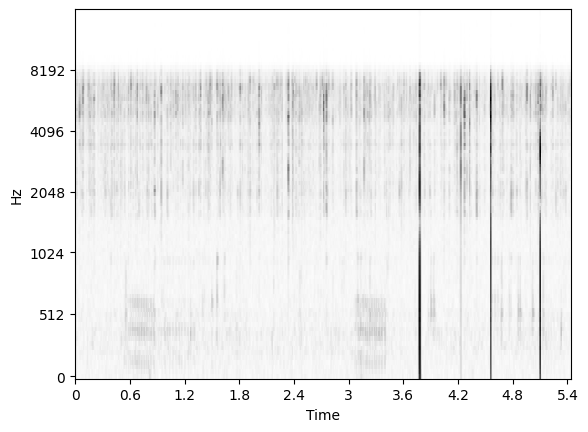

Target sound label:  pulse_purr


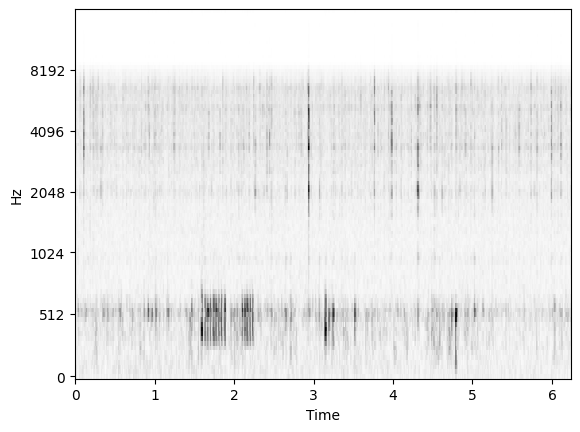

Target sound label:  yawn


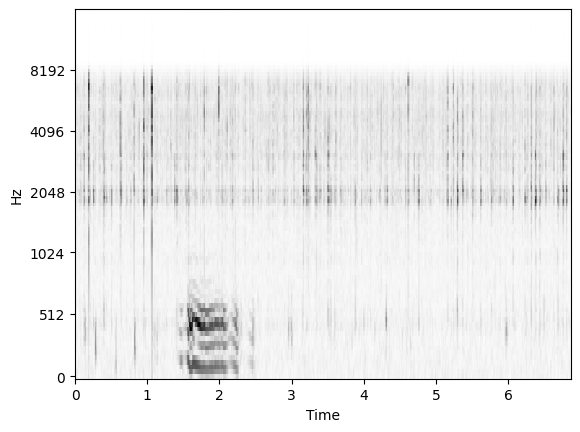

Target sound label:  pulse_train


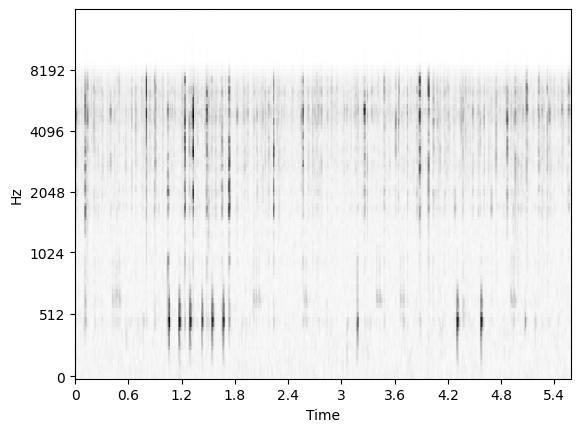

In [8]:
#@title { vertical-output: true }
# Path to cioc target sound folders
ls_target_sounds = os.listdir(all_target_sounds)

# For each target sound folder, find the first audio file as an example
example_target_sounds = []
for folder in ls_target_sounds:
  wav_files = [file for file in os.listdir(os.path.join(all_target_sounds, folder)) if file.lower().endswith('.wav')]
  example_sound_path = os.path.join(all_target_sounds, folder + '/' + wav_files[0])
  example_target_sounds.append(example_sound_path)

# Now view each example target sound
print('Number of different target sounds: ', len(example_target_sounds))
for audio_path in example_target_sounds:
  print('Target sound label: ', audio_path.split('/')[-2])
  audio = audio_utils.load_audio(audio_path, target_sample_rate = sample_rate)
  display.plot_audio_melspec(audio, sample_rate = sample_rate)

In [9]:
# @title Hit run on this cell and pick a target sound

# Ensure the path exists and list directories
if os.path.exists(all_target_sounds):
    sound_folders = [f for f in os.listdir(all_target_sounds) if os.path.isdir(os.path.join(all_target_sounds, f))]
else:
    print("Path does not exist:", all_target_sounds)
    sound_folders = []

# Create and display the dropdown
sound_dropdown = widgets.Dropdown(
    options=sound_folders,
    description='Select sound:',
    disabled=False,
)

# Define a function that reacts to changes in the dropdown
def on_sound_change(change):
    choice = change['new']
    print(f'Changed target sound to: {choice}')

# Attach the observer to the dropdown
sound_dropdown.observe(on_sound_change, names='value')

ipy_display(sound_dropdown)

Dropdown(description='Select sound:', options=('wipe', 'oink', 'laugh', 'rattle', 'scrape_fullband', 'scrape_l…

Changed target sound to: oink


In [10]:
#@title Set additional paths for newly selected target sound
target_sound = sound_dropdown.value

labeled_data_path = os.path.join(project_directory + '/target_sounds/', target_sound)
outputs_path = os.path.join(project_directory + '/agile_outputs/')
annotated_data_path = os.path.join(outputs_path, target_sound + '/labeled_outputs')
custom_classifier_path = os.path.join(outputs_path, target_sound + '/custom_classifier')
csv_output_filepath = os.path.join(outputs_path, target_sound + f'/{target_sound}_inference.csv')
validation_log_filepath = (os.path.join(outputs_path, target_sound + f'/validation_{target_sound}.csv'))

Number of indexed audio files in target sound directory: 4
Viewing example file: 1


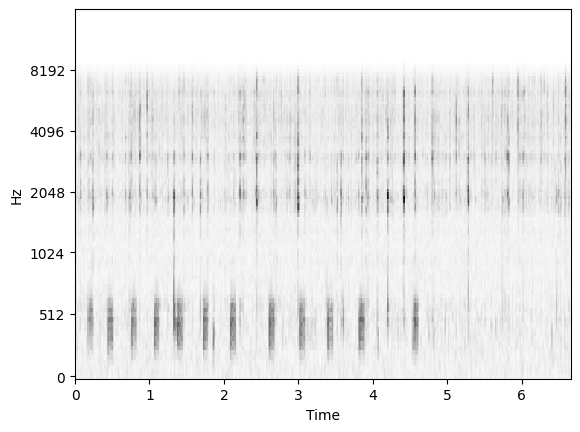

Viewing example file: 2


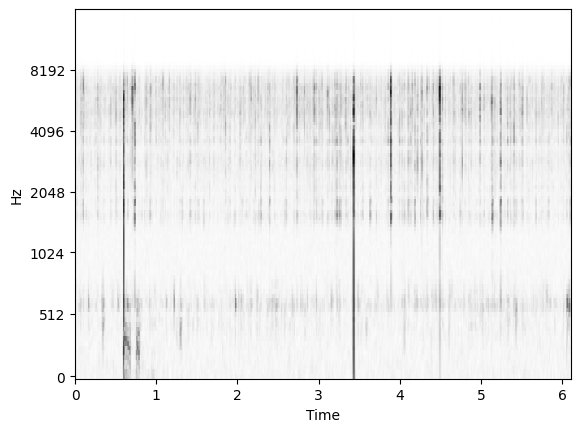

Viewing example file: 3


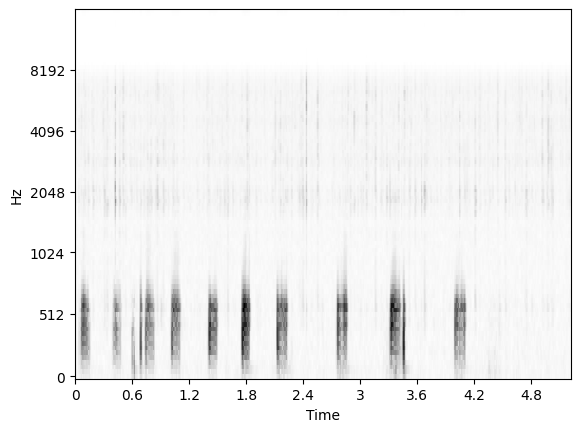

Viewing example file: 4


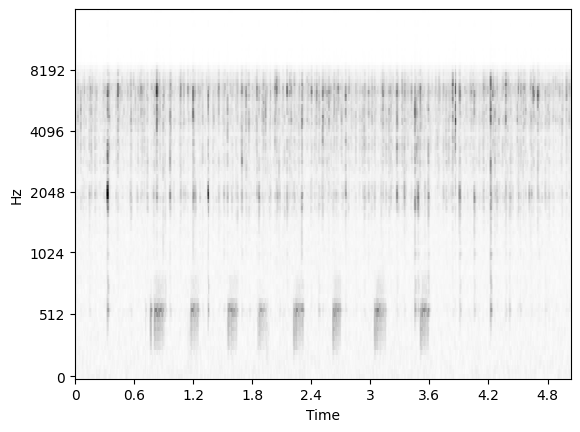

In [11]:
#@title Load and view examples of target sound { vertical-output: true }

# Select the target sound from the dropdown
target_sound = sound_dropdown.value

# Retrieve all .wav files for the selected target sound
wav_files = [file for file in os.listdir(labeled_data_path) if file.lower().endswith('.wav')]

# Print the total number of audio files
print(f"Number of indexed audio files in target sound directory: {len(wav_files)}")

# Loop through all the .wav files and display their melspectrogram
for file_index, wav_file in enumerate(wav_files):
    audio_path = os.path.join(labeled_data_path, wav_file)
    print(f"Viewing example file: {file_index + 1}")
    audio = audio_utils.load_audio(audio_path, sample_rate)
    display.plot_audio_melspec(audio, sample_rate)


Selected audio file: /home/bwilliams/ucl_projects/marrs_acoustics/data/output_dir_indonesia/target_sounds/oink/oink2.wav
Selected audio window:


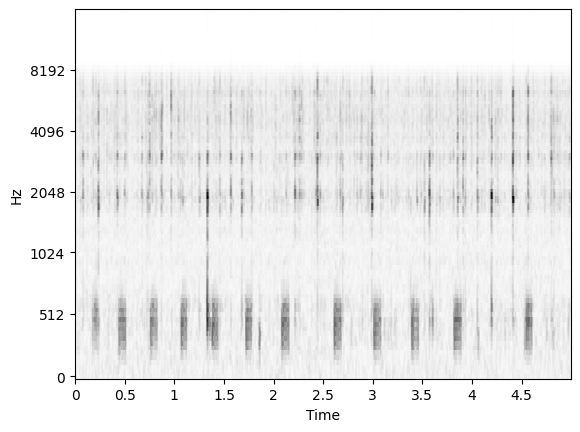

In [12]:
#@title Select audio clip { vertical-output: true }
# Choose one of the files from above
example_file = 1  #@param
file_index = example_file -1

# Set this file as the audio sample to move forward with
selected_audio_path = os.path.join(labeled_data_path, wav_files[file_index])
audio = audio_utils.load_audio(selected_audio_path, sample_rate)
print(f"Selected audio file: {selected_audio_path}")

# If you're audio clip is longer than 5s, adjust start_s to pick your
# prefered start time.
start_s = 0  #@param

# Display the selected window.
print('Selected audio window:')
st = int(start_s * sample_rate)
end = int(st + window_size * sample_rate)
if end > audio.shape[0]:
  end = audio.shape[0]
  st = max([0, int(end - window_size * sample_rate)])
audio_window = audio[st:end]
display.plot_audio_melspec(audio_window, sample_rate)

query_audio = audio_window
sep_outputs = None

In [13]:
#@title Copy existing labels to annotated data path
positive_matches = annotated_data_path + '/' + target_sound
if not os.path.exists(positive_matches):
  os.makedirs(positive_matches)

for file in os.listdir(labeled_data_path):
    if file.lower().endswith('.wav'):
        source_path = os.path.join(labeled_data_path, file)
        destination_path = os.path.join(positive_matches, file)
        shutil.copy2(source_path, destination_path)

In [34]:
bootstrap_config

BootstrapConfig(embeddings_path='/home/bwilliams/ucl_projects/marrs_acoustics/data/output_dir_indonesia/raw_embeddings/', annotated_path='/home/bwilliams/ucl_projects/marrs_acoustics/data/output_dir_indonesia/agile_outputs/oink/labeled_outputs', tensor_dtype='float32', embeddings_glob='embeddings-*', embedding_hop_size_s=5.0, file_id_depth=1, audio_globs=['/media/Backup/mars_global_acoustic_study/indonesia_acoustics/raw_audio/*.WAV'], model_key='taxonomy_model_tf', model_config=hop_size_s: 5.0
model_path: /home/bwilliams/ucl_projects/marrs_acoustics/SurfPerch-model
sample_rate: 32000
window_size_s: 5.0
, tf_record_shards=10)

In [26]:
#@title Load Project State and Models. { vertical-output: true }

if data_source == 'a2o':
  embedding_config = a2o_utils.get_a2o_embeddings_config()
  bootstrap_config = bootstrap.BootstrapConfig.load_from_embedding_config(
      embedding_config=embedding_config,
      annotated_path=labeled_data_path,
      embeddings_glob = '*/embeddings-*')
  embeddings_path = embedding_config.output_dir
elif (embeddings_path
      or (epath.Path(working_dir) / 'embeddings/config.json').exists()):
  if not embeddings_path:
    # Use the default embeddings path, as it seems we found a config there.
    embeddings_path = epath.Path(working_dir) / 'embeddings'
  # Get relevant info from the embedding configuration.
  bootstrap_config = bootstrap.BootstrapConfig.load_from_embedding_path(
      embeddings_path=embeddings_path,
      annotated_path=annotated_data_path) ###changed to prefered output dir
  if (bootstrap_config.model_key == 'separate_embed_model'
      and not separation_model_path.strip()):
    separation_model_key = 'separator_model_tf'
    separation_model_path = bootstrap_config.model_config.separator_model_tf_config.model_path
else:
  raise ValueError('No embedding configuration found.')

project_state = bootstrap.BootstrapState(
    bootstrap_config,
    embedding_model=embed_fn.embedding_model)

# Load separation model.
if separation_model_path:
  separation_config = config_dict.ConfigDict({
      'model_path': separation_model_path,
      'frame_size': 32000,
      'sample_rate': 32000,
  })
  separator = models.model_class_map()[
      separation_model_key].from_config(separation_config)
  print('Loaded separator model at {}'.format(separation_model_path))
else:
  print('No separation model loaded.')
  separator = None

No separation model loaded.


In [35]:
# ben added last night, above is old og code


# Use the embedded dataset that we created above...
bootstrap_config = bootstrap.BootstrapConfig.load_from_embedding_path(
    embeddings_path=embeddings_path,
    annotated_path=all_target_sounds
)

project_state = bootstrap.BootstrapState(
    bootstrap_config, embedding_model=embed_fn.embedding_model)

embeddings_ds = project_state.create_embeddings_dataset()

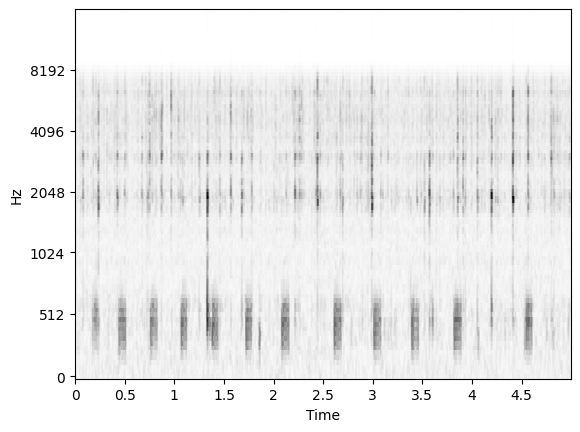

In [36]:
#@title Select the query channel. { vertical-output: true }

#@markdown Choose a name for the class.
query_label = target_sound
#@markdown If you have applied separation, choose a channel.
#@markdown Ignored if no separation model is being used.
query_channel = 0  #@param

if query_channel < 0 or sep_outputs is None:
  query_audio = audio_window
else:
  query_audio = sep_outputs.separated_audio[query_channel].copy()

display.plot_audio_melspec(query_audio, sample_rate)

# Embed the audio sample with our model to generate the query vector
outputs = project_state.embedding_model.embed(query_audio)
query = outputs.pooled_embeddings('first', 'first')


## Search embeddings with query

267691it [00:38, 7249.67it/s]2024-11-05 20:29:53.732119: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
267776it [00:38, 7029.81it/s]


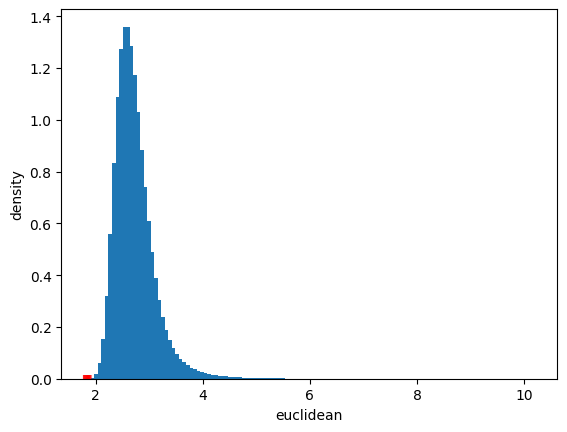

In [37]:
#@title Run Top-K Search. { vertical-output: true }

#@markdown Number of search results to capture.
top_k = 50  #@param

#@markdown Target distance for search results.
#@markdown This lets us try to hone in on a 'classifier boundary' instead of
#@markdown just looking at the closest matches.
#@markdown Set to 'None' for raw 'best results' search.
target_score = None  #@param

metric = 'euclidean'  #@param['euclidean', 'mip', 'cosine']

random_sample = False  #@param

ds = project_state.create_embeddings_dataset(shuffle_files=True)
results, all_scores = search.search_embeddings_parallel(
    ds, query,
    hop_size_s=bootstrap_config.embedding_hop_size_s,
    top_k=top_k, target_score=target_score, score_fn=metric,
    random_sample=random_sample)

# Plot histogram of distances
ys, _, _ = plt.hist(all_scores, bins=128, density=True)
hit_scores = [r.score for r in results.search_results]
plt.scatter(hit_scores, np.zeros_like(hit_scores), marker='|',
            color='r', alpha=0.5)

plt.xlabel(metric)
plt.ylabel('density')
if target_score is not None:
  plt.plot([target_score, target_score], [0.0, np.max(ys)], 'r:')
  # Compute the proportion of scores < target_score
  hit_percentage = (all_scores < target_score).mean()
  print(f'score < target_score percentage : {hit_percentage:5.3f}')
min_score = np.min(all_scores)
plt.plot([min_score, min_score], [0.0, np.max(ys)], 'g:')

plt.show()

## Annotate Search Results

NOTES:
- getting stuck here.
- firstly, I think I can clean up the project state stuff above by going to the surfperch tutorial. Currently it contains a load of if statements for a20 and source sep stuff I don't need.
- its saying it cant find the audio file raw_audio/ind_R6_20220923_063000.WAV. At first I though it might be because I changed the names of the embeddings dir, but I don't think thats the issue as it can clearly find the embeddings as it did search. So it can't seem to find the raw audio on the hard drive. Should it be the full filepath, not just 'raw_audio/ind_R6_20220923_063000.WAV'? In the tfrecord it is only saved as raw_audio/ind_R6_20220923_063000.WAV. So should it have saved the full path? Or should I be doing something with paths set further up to help this?
- am now rerunning embeddings as nothing to lose. try with these tomorrow. If this works, might need to rerun the other countries too.

In [31]:
import tensorflow as tf

# Path to your TFRecord file
file_path = "/home/bwilliams/ucl_projects/marrs_acoustics/data/output_dir_indonesia/raw_embeddings/embeddings-1723239728-00000-of-00010"

# Create a TFRecordDataset to read the TFRecord file
raw_dataset = tf.data.TFRecordDataset(file_path)

# Function to parse and print the first record in the TFRecord file
for raw_record in raw_dataset.take(1):
    example = tf.train.Example()
    example.ParseFromString(raw_record.numpy())
    print(example)


features {
  feature {
    key: "timestamp_s"
    value {
      float_list {
        value: -0
      }
    }
  }
  feature {
    key: "filename"
    value {
      bytes_list {
        value: "raw_audio/ind_D1_20220922_120200.WAV"
      }
    }
  }
  feature {
    key: "embedding"
    value {
      bytes_list {
        value: "\010\001\022\r\022\002\010\014\022\002\010\001\022\003\010\200\n\"\200\340\003z\316\002\275\270 ~\274(\030\203<\027\257.=z7\200=b\254+>f\205\216= _\324:*e\332\275Y\220u=\234\336\216\275\n\233!=\273\322\013\276\310\177\n;<\220A=\252\270\"<p\354\005\273h\023\345\274P\004\247;\232\021\360<\331\224!= \314\014\273v\360\257\275\264\272\277<l\313\350\275\374cp\274@\214\321\274\017\355\210<\302x-=Z!\233<jA\210\275\226\314\303\275\203\236\241\275`Z\304\273,\235\351\274\300\016\001:\370\310$>\304\020\246\273`\373\241<\022\037\343\274\307,G>\010\263\221\274l\\.=\035\306\335=[\035_=\002\244\270\275\352*\322\275\325\005\026\276\202(\371\274\250\014\217=D\201s<\027o\251=\340)\0

2024-11-05 20:17:52.120986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [38]:
#@title Display results. { vertical-output: true }

samples_per_page = 25
page_state = display.PageState(
    np.ceil(len(results.search_results) / samples_per_page))

display.display_paged_results(
    results, page_state, samples_per_page,
    project_state=project_state,
    embedding_sample_rate=project_state.embedding_model.sample_rate,
    exclusive_labels=False,
    checkbox_labels=[query_label, 'unknown'],
    max_workers=5,
)

# display.display_search_results(
#     project_state=project_state,
#     results=results,
#     embedding_sample_rate=sample_rate,
#     checkbox_labels=target_sound,
#     max_workers=5)

Results Page: 0 / 2


ValueError: No file found for file_id raw_audio/ind_R2_20220909_000600.WAV.

In [ ]:
#@title Write annotated examples. { vertical-output: true }
results.write_labeled_data(bootstrap_config.annotated_path,
                           project_state.embedding_model.sample_rate)

## Active Learning for a Target Class

In [ ]:
# @title Load+Embed the Labeled Dataset. { vertical-output: true }

#@markdown Time-pooling strategy for audio longer than the model's window size.
time_pooling = 'mean'  # @param

merged = data_lib.MergedDataset.from_folder_of_folders(
    base_dir=annotated_data_path,
    embedding_model=project_state.embedding_model,
    time_pooling=time_pooling,
    load_audio=False,
    target_sample_rate=-2,
    audio_file_pattern='*',
    embedding_config_hash=bootstrap_config.embedding_config_hash(),
)

# Label distribution
lbl_counts = np.sum(merged.data['label_hot'], axis=0)
print('num classes :', (lbl_counts > 0).sum())
print('mean ex / class :', lbl_counts.sum() / (lbl_counts > 0).sum())
print('min ex / class :', (lbl_counts + (lbl_counts == 0) * 1e6).min())

In [ ]:
#@title Train small model over embeddings. { vertical-output: true }

#@markdown Number of random training examples to choose from each class.
#@markdown Set exactly one of `train_ratio` and `train_examples_per_class`.
train_ratio = 0.8  #@param
train_examples_per_class = None  #@param

#@markdown Number of random re-trainings. Allows judging model stability.
num_seeds = 3  #@param

# Classifier training hyperparams.
# These should be good defaults.
batch_size = 32
num_epochs = 128
num_hiddens = -1
learning_rate = 1e-3

metrics = collections.defaultdict(list)
for seed in tqdm.tqdm(range(num_seeds)):
  if num_hiddens > 0:
    model = classify.get_two_layer_model(
        num_hiddens, merged.embedding_dim, merged.num_classes)
  else:
    model = classify.get_linear_model(
        merged.embedding_dim, merged.num_classes)
  run_metrics = classify.train_embedding_model(
      model, merged, train_ratio, train_examples_per_class,
      num_epochs, seed, batch_size, learning_rate)
  metrics['acc'].append(run_metrics.top1_accuracy)
  metrics['auc_roc'].append(run_metrics.auc_roc)
  metrics['cmap'].append(run_metrics.cmap_value)
  metrics['maps'].append(run_metrics.class_maps)
  metrics['test_logits'].append(run_metrics.test_logits)

mean_acc = np.mean(metrics['acc'])
mean_auc = np.mean(metrics['auc_roc'])
mean_cmap = np.mean(metrics['cmap'])
# Merge the test_logits into a single array.
test_logits = {
    k: np.concatenate([logits[k] for logits in metrics['test_logits']])
    for k in metrics['test_logits'][0].keys()
}

print(f'acc:{mean_acc:5.2f}, auc_roc:{mean_auc:5.2f}, cmap:{mean_cmap:5.2f}')
for lbl, auc in zip(merged.labels, run_metrics.class_maps):
  if np.isnan(auc):
    continue
  print(f'\n{lbl:8s}, auc_roc:{auc:5.2f}')
  colab_utils.prstats(f'test_logits({lbl})',
                      test_logits[merged.labels.index(lbl)])

In [ ]:
#@title Run model on target unlabeled data. { vertical-output: true }

#@markdown Choose the target class to work with.
target_class = target_sound  #@param
#@markdown Choose a target logit; will display results close to the target.
#@markdown Set to None to get the highest-logit examples.
target_logit = 0  #@param
#@markdown Number of results to display.
num_results = 200  #@param

embeddings_ds = project_state.create_embeddings_dataset(
    shuffle_files=True)
target_class_idx = merged.labels.index(target_class)
results, all_logits = search.classifer_search_embeddings_parallel(
    embeddings_classifier=model,
    target_index=target_class_idx,
    embeddings_dataset=embeddings_ds,
    hop_size_s=bootstrap_config.embedding_hop_size_s,
    target_score=target_logit,
    top_k=num_results
)

# Plot the histogram of logits.
ys, _, _ = plt.hist(all_logits, bins=128, density=True)
plt.xlabel(f'{target_class} logit')
plt.ylabel('density')
# plt.yscale('log')
plt.plot([target_logit, target_logit], [0.0, np.max(ys)], 'r:')
plt.show()


In [ ]:
#@title Display results for the target label. { vertical-output: true }

display_labels = merged.labels

#@markdown Specify any extra labels you would like displayed.
extra_labels = []  #@param
for label in extra_labels:
  if label not in merged.labels:
    display_labels += (label,)
if 'unknown' not in merged.labels:
  display_labels += ('unknown',)

samples_per_page = 25
page_state = display.PageState(
    np.ceil(len(results.search_results) / samples_per_page))

display.display_paged_results(
    results, page_state, samples_per_page,
    project_state=project_state,
    embedding_sample_rate=project_state.embedding_model.sample_rate,
    exclusive_labels=False,
    checkbox_labels=display_labels,
    max_workers=5,
)

In [ ]:
#@title Add selected results to the labeled data. { vertical-output: true }

results.write_labeled_data(
    bootstrap_config.annotated_path,
    project_state.embedding_model.sample_rate)

In [ ]:
#@title Save the Custom Classifier. { vertical-output: true }

wrapped_model = interface.LogitsOutputHead(
    model_path=custom_classifier_path,
    logits_key='logits',
    logits_model=model,
    class_list=namespace.ClassList('custom', merged.labels),
)
wrapped_model.save_model(
    custom_classifier_path,
    embeddings_path)

In [ ]:
#@title Write classifier inference CSV. { vertical-output: true }

#@markdown This cell writes detections (locations of audio windows where
#@markdown the logit was greater than a threshold) to a CSV file.

output_filepath = csv_output_filepath  #@param

#@markdown Set the default detection thresholds, used for all classes.
#@markdown To set per-class detection thresholds, modify the code below.
#@markdown Keep in mind that thresholds are on the logit scale, so 0.0
#@markdown corresponds to a 50% model confidence.
default_threshold = 0.0  #@param
if default_threshold is None:
  # In this case, all logits are written. This can lead to very large CSV files.
  class_thresholds = None
else:
  class_thresholds = collections.defaultdict(lambda: default_threshold)
  # Add any per-class thresholds here.
  class_thresholds[target_sound] = 1.0

#@markdown Classes to ignore when counting detections.
exclude_classes = ['unknown']  #@param

#@markdown The `include_classes` list is ignored if empty.
#@markdown If non-empty, only scores for these classes will be written.
include_classes = []  #@param

embeddings_ds = project_state.create_embeddings_dataset(
    shuffle_files=True)
classify.write_inference_csv(
    embeddings_ds=embeddings_ds,
    model=model,
    labels=merged.labels,
    output_filepath=output_filepath,
    threshold=class_thresholds,
    embedding_hop_size_s=bootstrap_config.embedding_hop_size_s,
    include_classes=include_classes,
    exclude_classes=exclude_classes)

# Call Density Validation

In [ ]:
cfg = config_dict.ConfigDict({
    'model_path': custom_classifier_path,
    'logits_key': 'custom',
})
logits_head = interface.LogitsOutputHead.from_config(cfg)
model = logits_head.logits_model
class_list = logits_head.class_list
print('Loaded custom model with classes: ')
print('\t' + '\n\t'.join(class_list.classes))

In [ ]:
#@title Validation and Call Density. { vertical-output: true }

target_class = target_sound  #@param {type:'string'}

#@markdown Bin bounds for validation. Should be an ordered list, beginning with
#@markdown 0.0 and ending with 1.0.
bounds = [0.0, 0.9, 0.99, 0.999, 1.0]  #@param
#@markdown Number of validation samples per bin.
samples_per_bin = 25  #@param

bounds = np.array(bounds)
num_bins = len(bounds) - 1

# Select `top_k`` so that we are reasonably sure to get at least samples_per_bin
# samples in the rarest bin in a randomly selected set of `top_k` examples.
bin_probs = bounds[1:] - bounds[:-1]
rarest_prob = np.min(bin_probs)
top_k = samples_per_bin  / rarest_prob * 2

embeddings_ds = project_state.create_embeddings_dataset(shuffle_files=True)
results, all_logits = search.classifer_search_embeddings_parallel(
    embeddings_classifier=logits_head,
    target_index=class_list.classes.index(target_class),
    random_sample=True,
    top_k=top_k,
    hop_size_s=bootstrap_config.embedding_hop_size_s,
    embeddings_dataset=embeddings_ds,
)

q_bounds = np.quantile(all_logits, bounds)
binned = [[] for _ in range(num_bins)]
for r in results.search_results:
  result_bin = np.argmax(r.score < q_bounds) - 1
  binned[result_bin].append(r)
binned = [np.random.choice(b, samples_per_bin, replace=False) for b in binned]

combined_results = []
for b in binned:
  combined_results.extend(b)
rng = np.random.default_rng(42)
rng.shuffle(combined_results)

ys, _, _, = plt.hist(all_logits, bins=100, density=True)
for q in q_bounds:
  plt.plot([q, q], [0.0, np.max(ys)], 'k:', alpha=0.75)
plt.show()


In [ ]:
#@title Display Results. { vertical-output: true }

samples_per_page = 25  #@param
page_state = display.PageState(
    np.ceil(len(combined_results) / samples_per_page))

display.display_paged_results(
    search.TopKSearchResults(len(combined_results), combined_results),
    page_state, samples_per_page,
    project_state=project_state,
    embedding_sample_rate=project_state.embedding_model.sample_rate,
    exclusive_labels=True,
    checkbox_labels=[target_class, f'not {target_class}', 'unsure'],
)

In [ ]:
#@title Collate results and write validation log. { vertical-output: true }

filenames = []
timestamp_offsets = []
scores = []
is_pos = []
weights = []
bins = []

# Compute the sampling weights for each bin.
bin_wts = [1.0 / 2**(k + 1) for k in range(num_bins - 1)]
bin_wts.append(bin_wts[-1])

for r in combined_results:
  if not r.label_widgets: continue
  value = r.label_widgets[0].value
  if value is None:
    continue
  filenames.append(r.filename)
  scores.append(r.score)
  timestamp_offsets.append(r.timestamp_offset)

  # Get the bin number and sampling weight for the search result.
  result_bin = np.argmax(r.score < q_bounds) - 1
  bins.append(result_bin)
  weights.append(bin_wts[result_bin])

  if value == target_class:
    is_pos.append(1)
  elif value == f'not {target_class}':
    is_pos.append(-1)
  elif value == 'unsure':
    is_pos.append(0)

label = [target_class for _ in range(len(filenames))]
log = pd.DataFrame({
    'filenames': filenames,
    'timestamp_offsets': timestamp_offsets,
    'scores': scores,
    'is_pos': is_pos,
    'weights': weights,
    'bins': bins,
})
log.to_csv(validation_log_filepath, mode='a')

In [ ]:
#@title delete
bounds = [0.0, 0.9, 0.99, 0.999, 1.0]  #@param
#@markdown Number of validation samples per bin.
samples_per_bin = 25  #@param

bounds = np.array(bounds)
num_bins = len(bounds) - 1

In [ ]:
#@title Estimate Call Density. { vertical-output: true }

import scipy

# Collect validated labels by bin.
bin_pos = [0 for i in range(num_bins)]
bin_neg = [0 for i in range(num_bins)]
for score, pos in zip(scores, is_pos):
  result_bin = np.argmax(score < q_bounds) - 1
  if pos == 1:
    bin_pos[result_bin] += 1
  elif pos == -1:
    bin_neg[result_bin] += 1

# Create beta distributions.
prior = 0.1
betas = [scipy.stats.beta(p + prior, n + prior)
         for p, n in zip(bin_pos, bin_neg)]
# MLE positive rate in each bin.
mle_b = np.array([bin_pos[b] / (bin_pos[b] + bin_neg[b] + 1e-6)
                  for b in range(num_bins)])
# Probability of each bin, P(b).
p_b = np.array([2**-k for k in range(1, num_bins)] + [2**(-num_bins + 1)])

# MLE total call density.
q_mle = np.dot(mle_b, p_b)

num_beta_samples = 10_000
q_betas = []
for _ in range(num_beta_samples):
  qs_pos = np.array([b.rvs(size=1)[0] for b in betas])  # P(+|b)
  q_beta = np.dot(qs_pos, p_b)
  q_betas.append(q_beta)

# Plot call density estimate.
plt.figure(figsize=(10, 5))
xs, ys, _ = plt.hist(q_betas, density=True, bins=25, alpha=0.25)
plt.plot([q_mle, q_mle], [0.0, np.max(xs)], 'k:', alpha=0.75,
         label='q_mle')

low, high = np.quantile(q_betas, [0.05, 0.95])
plt.plot([low, low], [0.0, np.max(xs)], 'g', alpha=0.75, label='low conf')
plt.plot([high, high], [0.0, np.max(xs)], 'g', alpha=0.75, label='high conf')

plt.xlim(0.0, 1.0)
plt.xlabel('Call Rate (q)')
plt.ylabel('P(q)')
plt.title(f'Call Density Estimation ({target_class})')
plt.legend()
plt.show()

print(f'MLE Call Density: {q_mle:.4f}')
print(f'(Low/MLE/High) Call Density Estimate: ({low:5.4f} / {q_mle:5.4f} / {high:5.4f})')


In [ ]:
#@title Naive Estimation of ROC-AUC for target class. { vertical-output: true }
#@markdown Computes ROC-AUC from the validation logs, with bin weighting.
#@markdown ROC-AUC is the overall probability that a random positive example
#@markdown has a higher classifier score than a random negative example.

# Probability of bins
p_b = [1.0 / 2**(k + 1) for k in range(num_bins - 1)]
p_b.append(p_b[-1])
p_b = np.array(p_b)

bin_pos, bin_neg = np.array(bin_pos), np.array(bin_neg)
# Compute P(z(+) > z(-))
# P(b_i|+) * P(b_k|-)
n_pos = np.sum(bin_pos)
n_neg = np.sum(bin_neg)
p_pos_b = np.array(bin_pos) / (bin_pos + bin_neg)
p_neg_b = np.array(bin_neg) / (bin_pos + bin_neg)
p_pos = np.sum(p_pos_b * p_b)
p_neg = np.sum(p_neg_b * p_b)

p_b_pos = p_pos_b * p_b / p_pos
p_b_neg = p_neg_b * p_b / p_neg
roc_auc = 0
# For off-diagonal bin pairs:
# Take the probability of drawing a pos from bin j and neg from bin i.
# If j > i, all pos examples are scored higher, so contributes directly to the
# total ROC-AUC.
for i in range(num_bins):
  for j in range(i + 1, num_bins):
    roc_auc += p_b_pos[j] * p_b_neg[i]

# For diagonal bin-pairs:
# Look at actual in-bin observations for diagonal contribution.
bins = np.array(bins)
is_pos = np.array(is_pos)

for b in range(num_bins):
  bin_pos_idxes = np.argwhere((bins == b) * (is_pos == 1))[:, 0]
  bin_neg_idxes = np.argwhere((bins == b) * (is_pos == -1))[:, 0]
  bin_pos_scores = np.array(scores)[bin_pos_idxes]
  bin_neg_scores = np.array(scores)[bin_neg_idxes]
  if bin_pos_scores.size == 0:
    continue
  if bin_neg_scores.size == 0:
    continue
  # Count total number of pairs where the pos examples have a higher score than
  # a negative example.
  hits = ((bin_pos_scores[:, np.newaxis]
           - bin_neg_scores[np.newaxis, :]) > 0).sum()
  bin_roc_auc = hits / (bin_pos_scores.size * bin_neg_scores.size)
  # Contribution is the probability of pulling both pos and neg examples
  # from this bin, multiplied by the bin's ROC-AUC.
  roc_auc += bin_roc_auc * p_b_pos[b] * p_b_neg[b]

print(f'ROC-AUC : {roc_auc:.3f}')